In [1]:
import fasttext

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import numpy as np


In [2]:
torch.cuda.is_available()

True

In [3]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim=2048, num_layers=2, dropout=0.1, offset=256):
        super().__init__()

        # build a list of dims: [input_dim, hidden_dim, hidden_dim-offset, ...]
        dims = [input_dim]
        for _ in range(num_layers):
            dims.append(dims[-1] == input_dim and hidden_dim or max(dims[-1] - offset, offset))

        layers = []
        for in_dim, out_dim in zip(dims, dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(dropout))

        # final sigmoid head
        layers.append(nn.Linear(dims[-1], 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x).view(-1)

In [4]:
# This is what typically the mapper is according to the MUSE paper
class Generator(nn.Module):
    def __init__(self, embedding_dimension):
        super(Generator, self).__init__()
        self.dimension = embedding_dimension
        self.model = nn.Sequential(nn.Linear(self.dimension, self.dimension), nn.ReLU())

    def forward(self, x):
        return self.model(x)

In [5]:
## Assume that we have a src embedding and target embeddings

def train(src_emb, tar_emb, generator, discriminator, num_epochs, config):
    # src_emb and tar_emb are the torch.Embeddings

    optimizer_for_discriminator = torch.optim.Adam(discriminator.parameters(), lr=config["discriminator_lr"]) 
    optimizer_for_generator = torch.optim.Adam(generator.parameters(), lr=config["generator_lr"])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    src_emb = src_emb.to(device)
    tar_emb = tar_emb.to(device)

    generator = generator.to(device)
    discriminator = discriminator.to(device)

    # Lists to store loss values
    discriminator_losses = []
    generator_losses = []

    for i in range(num_epochs):

        # Lets update the discriminator multiple times rather than once in a epoch

        for discr_steps in range(config["discriminator_train_steps"]):

            discriminator.train()

            # Sampling with replacement

            src_idx = torch.randint(0, src_emb.num_embeddings, (config["batch_size"],), device=device)
            tar_idx = torch.randint(0, tar_emb.num_embeddings, (config["batch_size"],), device=device)

            src_word_batch_embeddings = src_emb(src_idx.to(device))
            tar_word_batch_embeddings = tar_emb(tar_idx.to(device))
            
            linear_transformation_of_src_embeddings = generator(src_word_batch_embeddings.to(device)).detach() # no grad calculation is needed
            
            # Let the descriminator classify the transformed embeddings
            # If the descriminator is trained only with the fake data, then it always predicts the data as fake.
            # @ discr_predictions = discriminator(linear_transformation_of_src_embeddings) 
            # So, the descriminator has to be aware of both the fake and real data

            discriminator_input = torch.cat([linear_transformation_of_src_embeddings, tar_word_batch_embeddings], dim=0)
            # print("Shape of the discriminator : ", discriminator_input.shape)
            actual_output = torch.cat([torch.zeros(config["batch_size"]), torch.ones(config["batch_size"])], dim=0) # 0 for fake/generated 1 for real
            # print("Dimension of input layer of the discriminator : ", discriminator.model[0].in_features)
            pred_output = discriminator(discriminator_input.to(device))

            optimizer_for_discriminator.zero_grad() # Avoiding gradient accumulations
            discriminator_loss = nn.BCELoss()(pred_output.to(device), actual_output.to(device))
            discriminator_loss.backward()
            optimizer_for_discriminator.step()

            discriminator_losses.append(discriminator_loss.item())

        for gen_steps in range(config["generator_train_steps"]):
            src_idx = torch.randint(0, src_emb.num_embeddings, (config["batch_size"],))
            src_words = src_emb(src_idx.to(device))
            linear_transformation = generator(src_words.to(device))

            discri_prediction = discriminator(linear_transformation.to(device))
            fake_preds = torch.ones(config["batch_size"]) # the generator should learn to fool the discriminator

            optimizer_for_generator.zero_grad()
            generator_loss = nn.BCELoss()(discri_prediction.to(device), fake_preds.to(device))

            generator_loss.backward()
            optimizer_for_generator.step()

            generator_losses.append(generator_loss.item())

        if(i%100==0):
            print(f"Epoch {i}/{num_epochs} — D loss: {discriminator_losses[-1]:.4f}, G loss: {generator_losses[-1]:.4f}")

    plt.figure(figsize=(8,5))
    plt.plot(discriminator_losses, label="Discriminator Loss", alpha=0.7)
    plt.plot(generator_losses,     label="Generator Loss",     alpha=0.7)
    plt.xlabel("Training Steps")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return generator, discriminator

In [ ]:
model_hi_path = r"./custom_models/model_hi.bin"
model_en_path = r"./custom_models/model_en.bin"

model_hi = fasttext.load_model(model_hi_path)
model_en = fasttext.load_model(model_en_path)

In [7]:
# model_hi = fasttext.train_unsupervised("./TrainingReadyHindiText.txt")
# model_en = fasttext.train_unsupervised("./TrainingReadyEnglishText.txt")

In [98]:
src_vocab = model_en.get_words()
src_embedding_matrix = np.array([model_en.get_word_vector(word) for word in src_vocab])
tar_vocab = model_hi.get_words()
tar_embedding_matrix = np.array([model_hi.get_word_vector(word) for word in tar_vocab])

src_embedding_dim = model_en.get_dimension()
tar_embedding_dim = model_hi.get_dimension()

src_embed = nn.Embedding.from_pretrained(torch.tensor(src_embedding_matrix, dtype=torch.float32))
tar_embed = nn.Embedding.from_pretrained(torch.tensor(tar_embedding_matrix, dtype=torch.float32))

print("Size of the source embedding : ", src_embed.weight.shape)

# initialize the generator and discriminator
generator = Generator(src_embedding_dim)
discriminator = Discriminator(input_dim=src_embedding_dim, hidden_dim=1024, num_layers=3, dropout=0.1, offset=512)

config = {
    "discriminator_lr":0.00001,
    "generator_lr": 0.00001,
    "discriminator_train_steps": 1,
    "generator_train_steps": 1, #4
    "batch_size": 10 #256
}

Size of the source embedding :  torch.Size([38115, 100])


Epoch 0/1000 — D loss: 0.0692, G loss: 2.3180
Epoch 100/1000 — D loss: 0.0309, G loss: 3.0951
Epoch 200/1000 — D loss: 0.0146, G loss: 3.7806
Epoch 300/1000 — D loss: 0.0096, G loss: 4.5614
Epoch 400/1000 — D loss: 0.0056, G loss: 4.5299
Epoch 500/1000 — D loss: 0.0045, G loss: 5.1745
Epoch 600/1000 — D loss: 0.0029, G loss: 5.7612
Epoch 700/1000 — D loss: 0.0021, G loss: 5.5496
Epoch 800/1000 — D loss: 0.0012, G loss: 5.8755
Epoch 900/1000 — D loss: 0.0015, G loss: 5.9773


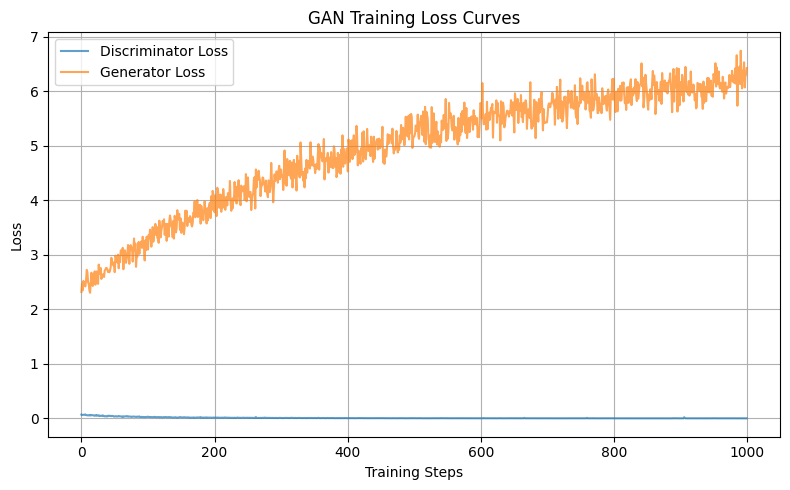

In [101]:
mapper, trained_discriminator = train(src_embed, tar_embed, generator, discriminator, num_epochs=1000, config=config)

In [10]:
# Save
torch.save(mapper.state_dict(), "unsupervised_mapper.pth")

In [51]:
from sklearn.metrics.pairwise import cosine_similarity

def get_similarities(word, word_embedding, fasttext_model):
    similarities = []

    for target_word in fasttext_model.get_words():
        target_embedding = fasttext_model.get_word_vector(target_word)
        similarity = cosine_similarity([word_embedding], [target_embedding])[0][0]
        similarities.append((target_word, similarity))

    return similarities

def get_top_k_pairs(similarities, k):
    top_k = sorted(similarities, key=lambda x: x[1], reverse=True)[:k]
    return [word for word, _ in top_k]


def generate_pseudo_translation_pairs(mapper, word, model_en, model_hi, k):
    mapper_cpu = mapper.to(torch.device("cpu"))
    
    with torch.no_grad():
        word_embedding = mapper_cpu(torch.tensor(model_en.get_word_vector(word)))

    similarities = get_similarities(word, word_embedding.to(torch.device("cpu")), model_hi)
    
    return get_top_k_pairs(similarities, k)

In [55]:
generate_pseudo_translation_pairs(mapper, "and", model_en, model_hi, 5)

['जैन', 'वस्ती', 'बस्ती', 'उन्नत', 'उन्नती']

In [52]:
def precision(muse_dict, mapper, model_en, model_hi, k):
    correct = 0
    total = len(muse_dict)
    for (en,hi) in zip(muse_dict.keys(), muse_dict.values()):
        generated_pairs_with_embedding = generate_pseudo_translation_pairs(mapper, en, model_en, model_hi, k)
        generated_words = [pair[0] for pair in generated_pairs_with_embedding]
        if hi in generated_words:
            correct += 1
            
    return correct/total

In [53]:
# Loading the muse en_hi parallel corpus dictionary
def create_dict(file_path, size=5000):
    en_hi = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            en, hi = line.strip().split()
            en_hi[en] = hi
            if(len(en_hi)==size):
                break

    return en_hi

In [61]:
muse_translation_dict = create_dict(r"../GeneratedDatasets/muse_crosslingual_en_hi/en-hi.txt", size=100)

In [62]:
print("Precision@1 : ", precision(muse_translation_dict, mapper, model_en, model_hi, k=1))
print("Precision@5 : ", precision(muse_translation_dict, mapper, model_en, model_hi, k=5))

Precision@1 :  0.0
Precision@5 :  0.0


In [ ]:
def get_average_k_similarity(vec, other_vectors, k=10):
    # step1 : compute the cosine similarity
    sims = cosine_similarity([vec], other_vectors)[0]
    top_k = sorted(sims, reverse=True)[:k]
    # step2 : Do the average and return
    return np.mean(top_k)

def get_csls_similarities(src_embedding, tgt_model, src_model=None, k_csls=10):
    tgt_words = tgt_model.get_words()
    tgt_vectors = [tgt_model.get_word_vector(word) for word in tgt_words]
    # step1 and step2
    r_src = get_average_k_similarity(src_embedding, tgt_vectors, k=k_csls)

    csls_similarities = []

    for word, tgt_vec in zip(tgt_words, tgt_vectors):
        r_tgt = get_average_k_similarity(tgt_vec, tgt_vectors, k=k_csls)
        cos_sim = cosine_similarity([src_embedding], [tgt_vec])[0][0]
        # step3 : apply csls formulae
        csls_score = 2 * cos_sim - r_src - r_tgt
        csls_similarities.append((word, csls_score))

    return csls_similarities

def generate_pseudo_translation_pairs_csls(mapper, word, model_en, model_hi, k, k_csls=10):
    mapper_cpu = mapper.to(torch.device("cpu"))

    with torch.no_grad():
        word_embedding = mapper_cpu(torch.tensor(model_en.get_word_vector(word))).detach().numpy()

    csls_similarities = get_csls_similarities(word_embedding, model_hi, model_en, k_csls=k_csls)
    
    return get_top_k_pairs(csls_similarities, k)


In [64]:
def precision_csls(muse_dict, mapper, model_en, model_hi, k, k_csls):
    correct = 0
    total = len(muse_dict)
    for (en,hi) in zip(muse_dict.keys(), muse_dict.values()):
        generated_pairs_with_embeddings = generate_pseudo_translation_pairs_csls(mapper, en, model_en, model_hi, k, k_csls)
        generated_words = [pair[0] for pair in generated_pairs_with_embeddings]
        if hi in generated_words:
            correct += 1
            
    return correct/total

In [100]:
# print("Precision@1 : ", precision_csls(muse_translation_dict, mapper, model_en, model_hi, k=1, k_csls=5))
# print("Precision@5 : ", precision_csls(muse_translation_dict, mapper, model_en, model_hi, k=5, k_csls=5))

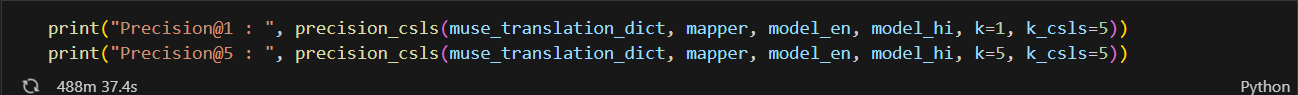